In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [144]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
date = session.query(measurement).order_by(measurement.date.desc()).first()
print(date.date)
date.__dict__

2017-08-23


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25c32882490>,
 'prcp': 0.0,
 'station': 'USC00519397',
 'tobs': 81.0,
 'id': 2724,
 'date': '2017-08-23'}

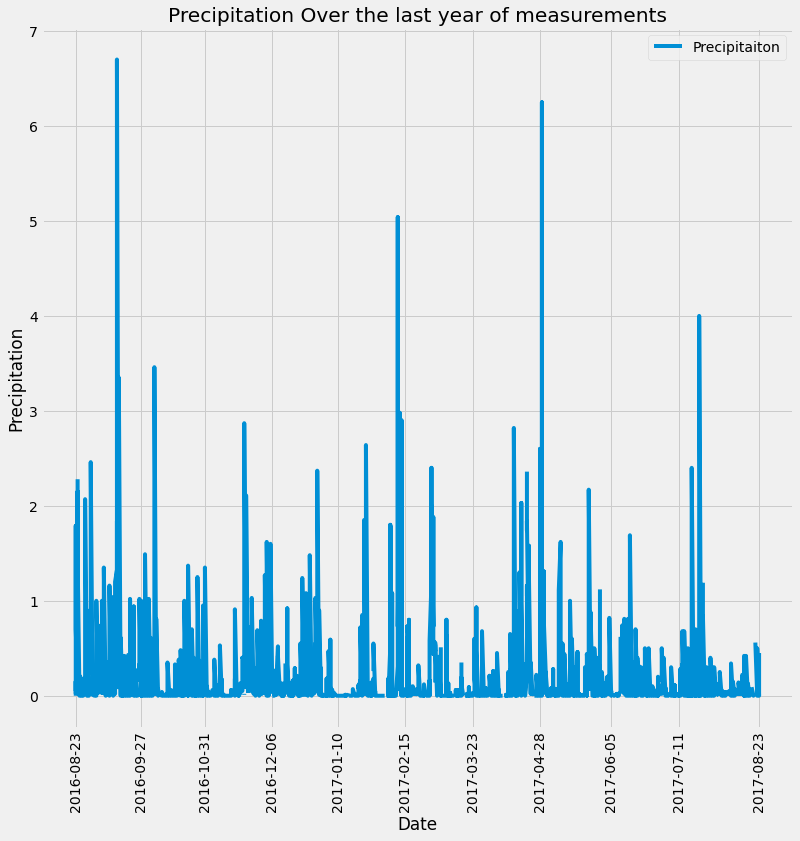

In [156]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_order = session.query(measurement).order_by(measurement.date.asc()).filter(measurement.date >= '2016-08-23').all()

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores
dates = []
precip = []
index = []
i = 0
# Save the query results as a Pandas DataFrame and set the index to the date column
for date in date_order:
    dates.append(date.date)
    precip.append(date.prcp)
    index.append(i)
    i+=1
df = pd.DataFrame(zip(dates,precip))
df = df.rename(columns={0:'Date', 1: 'Precipitation'})
df
# Sort the dataframe by date
total = len(dates)
steps = total/10
steps = int(steps)
total = total-1
specific = range(0, total, steps)
xlabels = []
for val in specific:
    xlabels.append(df.iloc[val].Date)
xlabels.append(df.iloc[total].Date)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=[12,12])
plt.plot(df['Date'], df['Precipitation'], label='Precipitaiton')
plt.xticks(xlabels,rotation=90)
plt.title('Precipitation Over the last year of measurements')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [131]:
# Design a query to calculate the total number stations in the dataset
info = session.query(station).order_by(station.station).distinct().count()
print(info)

9


In [104]:
test = session.query(station).first()
test.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25c3b5e0850>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1}

In [128]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_names = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print(station_names)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [142]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(measurement.tobs, func.min(measurement.tobs)).filter(measurement.station == station_names[0][0]).all()
lowest_temp = lowest_temp[0][0]
highest_temp = session.query(measurement.tobs, func.max(measurement.tobs)).filter(measurement.station == station_names[0][0]).all()
highest_temp = highest_temp[0][0]
avg_temp = session.query(measurement.tobs, func.avg(measurement.tobs)).filter(measurement.station == station_names[0][0]).all()
avg_temp = avg_temp[0][1]
avg_temp
print(f'The lowest temp is {lowest_temp}, the highest temp is {highest_temp}, and the average temp is {avg_temp} at the {station_names[0][0]} station')

The lowest temp is 54.0, the highest temp is 85.0, and the average temp is 71.66378066378067 at the USC00519281 station


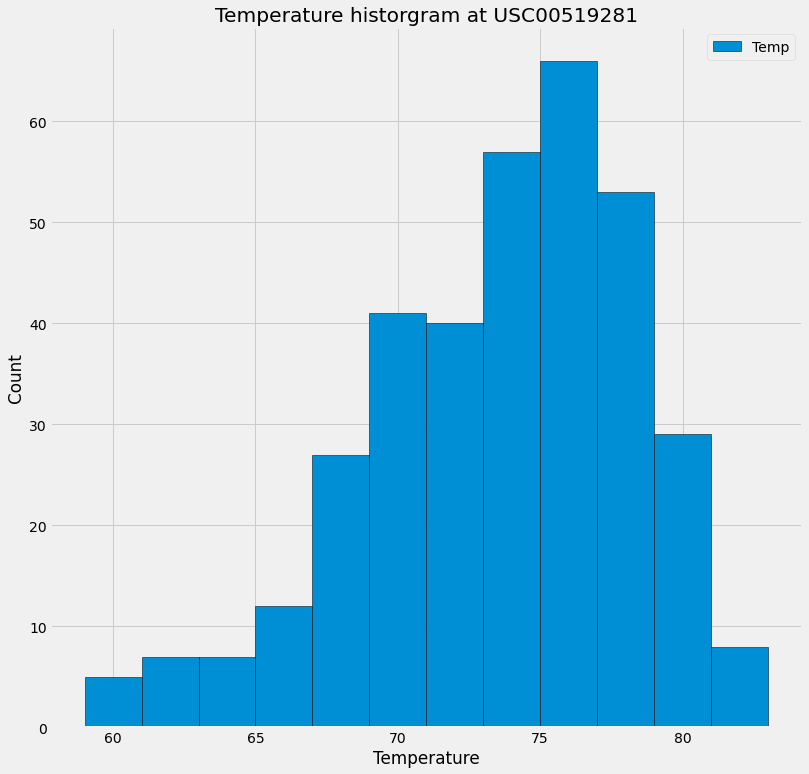

In [155]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
and_order = session.query(measurement).order_by(measurement.date.asc()).filter(and_(measurement.date >= '2016-08-23', measurement.station == station_names[0][0])).all()
temp_info = []
for val in and_order:
    temp_info.append(val.tobs)
new_df = pd.DataFrame(temp_info)
new_df = new_df.rename(columns={0:'Temperature'})
plt.figure(figsize=[12,12])
plt.hist(new_df, bins=12, ec='black', label='Temp')
plt.title(f'Temperature historgram at {station_names[0][0]}')
plt.ylabel('Count')
plt.xlabel('Temperature')
plt.legend()
plt.show()

# Close session

In [157]:
# Close Session
session.close()